### Objective:
Build a clinically interpretable heart disease risk screening model optimized for high recall to minimize false negatives.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv("Framingham_Heart_Disease.csv")
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [27]:
df.drop(columns = ["education"], inplace = True)

In [28]:
df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [29]:
df.isnull().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [30]:
df.fillna(df.median(), inplace = True)
X = df.drop(columns=["TenYearCHD"])
y = df["TenYearCHD"]

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter = 3000, class_weight="balanced"))
])

In [33]:
from sklearn.model_selection import GridSearchCV

params = {"lr__C" : [0.001, 0.01, 0.1, 1, 10, 100]}
classification_regressor = GridSearchCV(model, param_grid = params, scoring = "roc_auc", cv = 5)

In [34]:
classification_regressor.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=3000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'lr__C': [0.001, 0.01, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candidat

In [35]:
classification_regressor.best_params_

{'lr__C': 0.01}

In [36]:
print("Mean ROC-AUC:", classification_regressor.best_score_)
print("Std ROC-AUC:", classification_regressor.cv_results_['std_test_score'][classification_regressor.best_index_])

Mean ROC-AUC: 0.7325149852258338
Std ROC-AUC: 0.024415625292360348


In [37]:
best_model = classification_regressor.best_estimator_
y_pred = best_model.predict(X_test)

In [38]:
coef = best_model.named_steps['lr'].coef_[0]
feature_importance = pd.Series(coef, index=X.columns)
print(feature_importance.sort_values())

heartRate         -0.014698
BMI                0.023338
diaBP              0.029963
currentSmoker      0.030468
diabetes           0.054886
prevalentStroke    0.072400
BPMeds             0.076889
prevalentHyp       0.095607
totChol            0.096329
glucose            0.113822
male               0.182018
sysBP              0.236401
cigsPerDay         0.237215
age                0.519302
dtype: float64


In [39]:
y_prob = best_model.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.4).astype(int)

#### When the classes were imbalanced...f1 score for class 1 was 0.12 but after balancing it is 0.35. This shows the importance of balanced dataset

In [40]:
from sklearn.metrics import (f1_score, classification_report, confusion_matrix, accuracy_score, precision_recall_curve, auc,
roc_auc_score)
print("Accuracy:-", accuracy_score(y_test, y_pred))
print("f1 score:-",f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)

test_auc = roc_auc_score(y_test, y_prob)
print("Test ROC-AUC:", test_auc)

Accuracy:- 0.5495283018867925
f1 score:- 0.34812286689419797
              precision    recall  f1-score   support

           0       0.93      0.51      0.66       719
           1       0.22      0.79      0.35       129

    accuracy                           0.55       848
   macro avg       0.58      0.65      0.50       848
weighted avg       0.82      0.55      0.61       848

PR-AUC: 0.2958031327713557
Test ROC-AUC: 0.6990221129691324


In [41]:
# [TP, TN
#  FP, FN]
print(confusion_matrix(y_test, y_pred))

[[364 355]
 [ 27 102]]


#### Scores at different stages
| Stage                    | Recall(1) | Precision(1) | F1(1) |
| ------------------------ | --------- | ------------ | ----- |
| No balancing             | 0.50      | 0.07         | 0.12  |
| Balanced (0.5 threshold) | 0.58      | 0.25         | 0.35  |
| Threshold 0.4            | 0.77      | 0.22         | 0.35  |

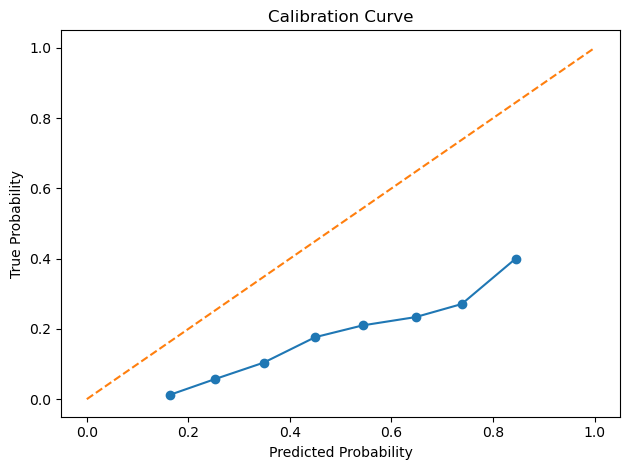

In [42]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.tight_layout()

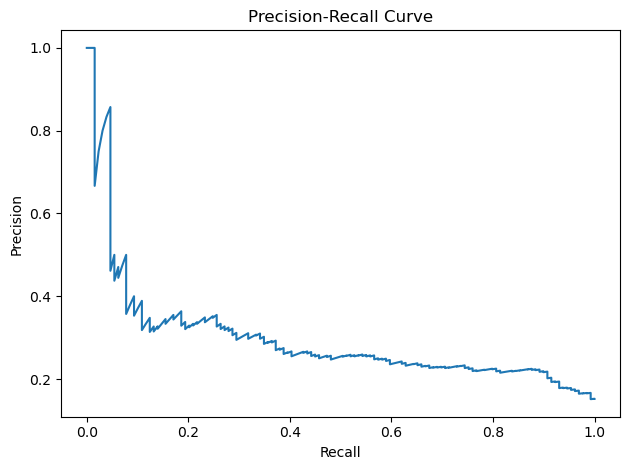

In [43]:
from sklearn.metrics import precision_recall_curve
y_prob = best_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()

#### What this Precision-Recall Curve tells -
- Logistic regression has limited separation power on this dataset.
- Model struggles separating positives cleanly.
- Many predicted positives are actually false positives.

In [44]:
f1 = "age"
f2 = "sysBP"

x_min, x_max = X[f1].min(), X[f1].max()
y_min, y_max = X[f2].min(), X[f2].max()
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 150),
    np.linspace(y_min, y_max, 150)
)

fixed_values = X.median()
# make fake dataset for prediction
grid_data = []
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        row = fixed_values.copy()
        row[f1] = xx[i, j]
        row[f2] = yy[i, j]
        grid_data.append(row)
grid_df = np.vstack(grid_data)

grid_df = pd.DataFrame(grid_data, columns=X.columns)

Z = best_model.predict_proba(grid_df)[:, 1]
Z = Z.reshape(xx.shape)

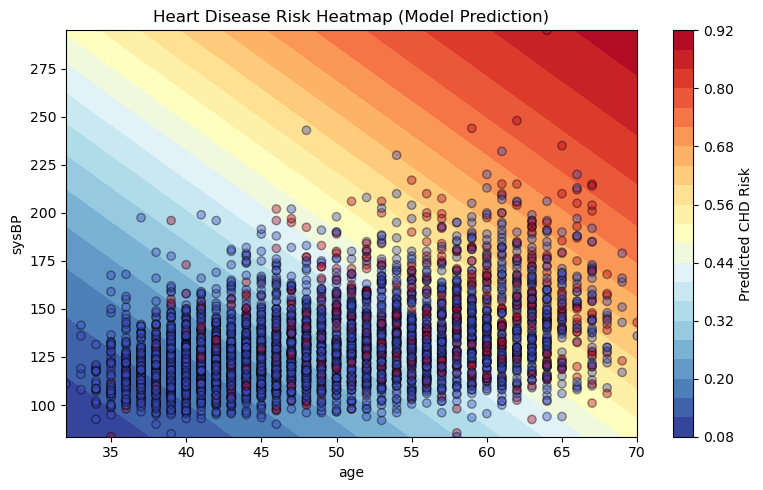

In [45]:
plt.figure(figsize=(8,5))
plt.contourf(xx, yy, Z, levels=25, cmap="RdYlBu_r")
plt.colorbar(label="Predicted CHD Risk")
plt.scatter(
    X[f1],
    X[f2],
    c=y,
    cmap="coolwarm",
    alpha=0.4,
    edgecolor="k"
)
plt.xlabel(f1)
plt.ylabel(f2)
plt.title("Heart Disease Risk Heatmap (Model Prediction)")
plt.tight_layout()

In [46]:
import joblib
joblib.dump(best_model, "model.pkl")
# joblib.dump(best_model, "scaler.pkl")

['model.pkl']

### 📌 Final Conclusion

This project aimed to develop a clinically interpretable heart disease risk prediction model using the Framingham dataset. The objective was to build a screening-oriented model that prioritizes recall to minimize false negatives in early cardiovascular risk detection.

A Logistic Regression model with median imputation, feature scaling, and class balancing was implemented within a pipeline and optimized using 5-fold stratified cross-validation.

#### Key Results:
- Cross-Validated ROC-AUC: 0.73 ± 0.02
- Test ROC-AUC: 0.70
- PR-AUC: 0.30
- Recall (Class 1): ~0.79 (at threshold = 0.4)
- F1-score (Class 1): 0.35

The model demonstrates moderate discriminative ability and stable generalization performance. Threshold adjustment improved recall significantly, making the model more suitable for screening applications where minimizing missed high-risk individuals is critical.

Feature coefficient analysis revealed that:
- Age is the strongest risk predictor.
- Higher systolic blood pressure increases CHD risk.
- Smoking intensity contributes positively to risk.
- Diabetes and cholesterol levels also show meaningful influence.
- These findings align with established cardiovascular risk factors, reinforcing the clinical validity of the model.

#### ⚠ Limitations
- The dataset is moderately imbalanced, affecting precision.
- PR-AUC indicates limited separation power for minority class.
- Logistic regression assumes linear relationships.
- No external dataset validation was performed.
- Calibration curve shows slight probability overestimation.

#### 🔮 Future Improvements
- Evaluate non-linear models (e.g., Gradient Boosting).
- Apply probability calibration (Platt scaling or isotonic regression).
- Perform external validation on independent cohorts.
- Incorporate feature engineering for interaction effects.
- Deploy as a probability-based risk scoring API.

#### 🏁 Final Assessment

The model is suitable as a risk screening tool, not a diagnostic system. It provides stable, interpretable, and clinically aligned predictions, making it a strong foundation for real-world ML healthcare applications.